In [ ]:
# Install gdown if not already installed
!pip install --quiet gdown

In [ ]:
from google.colab import drive, files
import os
import numpy as np
import cv2
import glob
import pandas as pd
import json
from matplotlib import pyplot as plt
import torch
import gdown
import traceback

In [ ]:
# Execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cpu device


In [ ]:
def download_and_extract_tar(file_id, folder_name='data', downloaded_file='data.tar'):
    """
    Downloads a .tar file from Google Drive, extracts it to a specified folder,
    and deletes the .tar file after extraction.

    Parameters:
      - file_id (str): The file ID of the .tar file on Google Drive.
      - folder_name (str): The folder where the .tar content will be extracted. Defaults to 'data'.
      - downloaded_file (str): The name to save the downloaded .tar file as. Defaults to 'data.tar'.
    """

    # Download the file from Google Drive using gdown
    gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', downloaded_file, quiet=False)

    # Create a folder to extract the files
    os.makedirs(folder_name, exist_ok=True)

    # Extract the .tar file into the folder
    os.system(f'tar -xf {downloaded_file} -C {folder_name}')

    # List the extracted files to verify
    print(f"Files extracted to '{folder_name}':")
    os.system(f'ls {folder_name}')

    # Remove the .tar file
    if os.path.exists(downloaded_file):
        os.remove(downloaded_file)
        print(f"{downloaded_file} deleted successfully.")
    else:
        print(f"{downloaded_file} does not exist.")


In [ ]:
file_id = '1-ZciGB5VJK544sZCafYaukbjsHDCQagH'
download_and_extract_tar(file_id)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1-ZciGB5VJK544sZCafYaukbjsHDCQagH
From (redirected): https://drive.google.com/uc?export=download&id=1-ZciGB5VJK544sZCafYaukbjsHDCQagH&confirm=t&uuid=4fc230d6-22bc-4880-bda9-a3848f025310
To: /content/data.tar
100%|██████████| 4.34G/4.34G [01:17<00:00, 55.8MB/s]


Files extracted to 'data':
data.tar deleted successfully.


In [ ]:
def read_data_in_chunks(file, cols=None, chunk_size=500000, nr_chunks=-1, criteria=None):
    """
    Reads large JSON files in chunks to avoid memory overload. Allows filtering columns
    and applying criteria for filtering rows.

    Parameters:
    file (str): Path to the JSON file.
    cols (list): List of columns to be extracted from each chunk. If None, all columns are read.
    chunk_size (int): Number of rows per chunk.
    nr_chunks (int): Number of chunks to read. If -1, reads until the file ends.
    criteria (function): A function to filter rows in the DataFrame.

    Returns:
    pd.DataFrame: A concatenated DataFrame from all chunks.
    """

    print(f'Reading JSON file in chunks from {file}...')

    try:
        # Initialize the JSON reader
        reader = pd.read_json(path_or_buf=file, chunksize=chunk_size, lines=True)
    except ValueError as e:
        print(f'Error! Failed to read file {file}. Reason: {e}')
        return None

    chunk_list = []
    chunks_read = 0

    while nr_chunks != 0:
        try:
            # Read next chunk
            chunk = next(reader)
            chunks_read += 1

            # Extract specific columns if provided
            if cols is not None:
                chunk = chunk[cols]

            # Apply criteria to filter rows
            if criteria is not None:
                chunk = criteria(chunk)

            chunk_list.append(chunk)
            print(f'Chunk {chunks_read} read: Shape {chunk.shape}')

        except StopIteration:
            print('Info: No more chunks to read.')
            break
        except Exception as e:
            print(f'Error while processing chunk {chunks_read}: {e}')
            print(traceback.format_exc())
            break

        nr_chunks -= 1

    if chunk_list:
        try:
            # Concatenate all chunks into a single DataFrame
            result_df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
            print(f'Concatenation complete. Final DataFrame shape: {result_df.shape}')
            return result_df
        except Exception as e:
            print(f'Error while concatenating chunks: {e}')
            print(traceback.format_exc())
            return None
    else:
        print('Warning: No chunks were processed.')
        return None

In [ ]:
base_wdir = '/content/data/'

In [ ]:
business_path = base_wdir + 'yelp_academic_dataset_business.json'

business_dataframe = read_data_in_chunks(business_path)

print(f'Shape: {business_dataframe.shape}')
business_dataframe.head()

Reading JSON file in chunks from /content/data/yelp_academic_dataset_business.json...
Chunk 1 read: Shape (150346, 14)
Info: No more chunks to read.
Concatenation complete. Final DataFrame shape: (150346, 14)
Shape: (150346, 14)


business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.955505  -75.155564    4.0            80        1   
4  40.338183  -75.471659    4.5            13        1   

                                          attributes  \
0                      {'ByAppointmentOnly': 'True'}   
1             {'BusinessAcceptsCreditCards': 'True'}   
2  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4  {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   
2  Department Stores, Shopping, Fashion, Home & G...   
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                          Brewpubs, Breweries, Food   

                                               hours  
0                                               None  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...  
2  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
4  {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...

In [ ]:
checkin_path = base_wdir + 'yelp_academic_dataset_checkin.json'

checkin_dataframe = read_data_in_chunks(checkin_path)

print(f'Shape: {checkin_dataframe.shape}')
checkin_dataframe.head()


Reading JSON file in chunks from /content/data/yelp_academic_dataset_checkin.json...
Chunk 1 read: Shape (131930, 2)
Info: No more chunks to read.
Concatenation complete. Final DataFrame shape: (131930, 2)
Shape: (131930, 2)


business_id                                               date
0  ---kPU91CF4Lq2-WlRu9Lw  2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020...
1  --0iUa4sNDFiZFrAdIWhZQ  2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011...
2  --30_8IhuyMHbSOcNWd6DQ           2013-06-14 23:29:17, 2014-08-13 23:20:22
3  --7PUidqRWpRSpXebiyxTg  2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012...
4  --7jw19RH9JKXgFohspgQw  2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014...

In [ ]:
review_path = base_wdir + 'yelp_academic_dataset_review.json'

review_dataframe = read_data_in_chunks(review_path)

print(f'Shape: {review_dataframe.shape}')
review_dataframe.head()

Reading JSON file in chunks from /content/data/yelp_academic_dataset_review.json...
Chunk 1 read: Shape (500000, 9)
Chunk 2 read: Shape (500000, 9)
Chunk 3 read: Shape (500000, 9)
Chunk 4 read: Shape (500000, 9)
Chunk 5 read: Shape (500000, 9)
Chunk 6 read: Shape (500000, 9)
Chunk 7 read: Shape (500000, 9)
Chunk 8 read: Shape (500000, 9)
Chunk 9 read: Shape (500000, 9)
Chunk 10 read: Shape (500000, 9)
Chunk 11 read: Shape (500000, 9)
Chunk 12 read: Shape (500000, 9)
Chunk 13 read: Shape (500000, 9)
Chunk 14 read: Shape (490280, 9)
Info: No more chunks to read.
Concatenation complete. Final DataFrame shape: (6990280, 9)
Shape: (6990280, 9)


review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   
2      3       0      0     0   
3      5       1      0     1   
4      4       1      0     1   

                                                text                date  
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm... 2014-02-05 20:30:30  
3  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03  
4  Cute interior and owner (?) gave us tour of up... 2017-01-14 20:54:15

In [ ]:
tip_path = base_wdir + 'yelp_academic_dataset_tip.json'

tip_dataframe = read_data_in_chunks(tip_path)

print(f'Shape: {tip_dataframe.shape}')
tip_dataframe.head()

Reading JSON file in chunks from /content/data/yelp_academic_dataset_tip.json...
Chunk 1 read: Shape (500000, 5)
Chunk 2 read: Shape (408915, 5)
Info: No more chunks to read.
Concatenation complete. Final DataFrame shape: (908915, 5)
Shape: (908915, 5)


user_id             business_id  \
0  AGNUgVwnZUey3gcPCJ76iw  3uLgwr0qeCNMjKenHJwPGQ   
1  NBN4MgHP9D3cw--SnauTkA  QoezRbYQncpRqyrLH6Iqjg   
2  -copOvldyKh1qr-vzkDEvw  MYoRNLb5chwjQe3c_k37Gg   
3  FjMQVZjSqY8syIO-53KFKw  hV-bABTK-glh5wj31ps_Jw   
4  ld0AperBXk1h6UbqmM80zw  _uN0OudeJ3Zl_tf6nxg5ww   

                                                text                date  \
0                     Avengers time with the ladies. 2012-05-18 02:17:21   
1  They have lots of good deserts and tasty cuban... 2013-02-05 18:35:10   
2             It's open even when you think it isn't 2013-08-18 00:56:08   
3                          Very decent fried chicken 2017-06-27 23:05:38   
4             Appetizers.. platter special for lunch 2012-10-06 19:43:09   

   compliment_count  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

# DATA EXPLORATION-BUSINESS

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter

In [ ]:
business_dataframe

business_id                      name  \
0       Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1       mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2       tUFrWirKiKi_TAnsVWINQQ                    Target   
3       MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4       mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   
...                        ...                       ...   
150341  IUQopTMmYQG-qRtBk-8QnA              Binh's Nails   
150342  c8GjPIOTGVmIemT7j5_SyQ      Wild Birds Unlimited   
150343  _QAMST-NrQobXduilWEqSw         Claire's Boutique   
150344  mtGm22y5c2UHNXDFAjaPNw  Cyclery & Fitness Center   
150345  jV_XOycEzSlTx-65W906pg                   Sic Ink   

                                address           city state postal_code  \
0                1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1       87 Grasso Plaza Shopping Center         Affton    MO       63123   
2                  5255 E Broadway Blvd         Tucson    AZ       85711   
3                           935 Race St   Philadelphia    PA       19107   
4                         101 Walnut St     Green Lane    PA       18054   
...                                 ...            ...   ...         ...   
150341                3388 Gateway Blvd       Edmonton    AB     T6J 5H2   
150342               2813 Bransford Ave      Nashville    TN       37204   
150343           6020 E 82nd St, Ste 46   Indianapolis    IN       46250   
150344                     2472 Troy Rd   Edwardsville    IL       62025   
150345            238 Apollo Beach Blvd   Apollo beach    FL       33572   

         latitude   longitude  stars  review_count  is_open  \
0       34.426679 -119.711197    5.0             7        0   
1       38.551126  -90.335695    3.0            15        1   
2       32.223236 -110.880452    3.5            22        0   
3       39.955505  -75.155564    4.0            80        1   
4       40.338183  -75.471659    4.5            13        1   
...           ...         ...    ...           ...      ...   
150341  53.468419 -113.492054    3.0            13        1   
150342  36.115118  -86.766925    4.0             5        1   
150343  39.908707  -86.065088    3.5             8        1   
150344  38.782351  -89.950558    4.0            24        1   
150345  27.771002  -82.394910    4.5             9        1   

                                               attributes  \
0                           {'ByAppointmentOnly': 'True'}   
1                  {'BusinessAcceptsCreditCards': 'True'}   
2       {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3       {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4       {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   
...                                                   ...   
150341  {'ByAppointmentOnly': 'False', 'RestaurantsPri...   
150342  {'BusinessAcceptsCreditCards': 'True', 'Restau...   
150343  {'RestaurantsPriceRange2': '1', 'BusinessAccep...   
150344  {'BusinessParking': '{'garage': False, 'street...   
150345  {'WheelchairAccessible': 'True', 'BusinessAcce...   

                                               categories  \
0       Doctors, Traditional Chinese Medicine, Naturop...   
1       Shipping Centers, Local Services, Notaries, Ma...   
2       Department Stores, Shopping, Fashion, Home & G...   
3       Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                               Brewpubs, Breweries, Food   
...                                                   ...   
150341                         Nail Salons, Beauty & Spas   
150342  Pets, Nurseries & Gardening, Pet Stores, Hobby...   
150343  Shopping, Jewelry, Piercing, Toy Stores, Beaut...   
150344  Fitness/Exercise Equipment, Eyewear & Optician...   
150345  Beauty & Spas, Permanent Makeup, Piercing, Tattoo   

                                                    hours  
0                                                    None  
1       {'Monday': '0:0-0:0', 'Tuesday': '

In [ ]:
# Load the dataset from the JSON file
file_path = '/content/data/yelp_academic_dataset_business.json'  # Corrected file path
df = pd.read_json(file_path, lines=True)

In [ ]:
# Numbers of the dataset-"shape"
print(f"Dataset shape: {df.shape}")

Dataset shape: (150346, 14)


There are 150346 Businesses and 14 features.

In [ ]:
# Data types of each column
print("\nData types of each column present in yelp dataset:")
print(df.dtypes)


Data types of each column present in yelp dataset:
business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


In [ ]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes      13744
categories        103
hours           23223
dtype: int64


Contains business data including location data, attributes, and categories

business_id: string, 22 character unique string business id,

name: string, the business's name,

address: string, the full address of the business,

city: string, the city

state: string, 2 character state code, if applicable

postal code: string, the postal code,

latitude: float, latitude,

longitude: float, longitude,

stars: float, star rating, rounded to half-stars,the average star rating of businesses

review_count: integer, the total number of reviews a business has received

is_open: integer, binary value where 1 indicates the business is open and 0 means it is closed.

attributes: object, business attributes to values. note: some attribute values might be objects {

In [ ]:
# Unique values in categorical features
print("\nUnique values, per feature:")
for col in ['business_id', 'name', 'city', 'state', 'postal_code']:
    print(f"{col}: {df[col].nunique()}")


Unique values, per feature:
business_id: 150346
name: 114117
city: 1416
state: 27
postal_code: 3362


# Nova secção

In [ ]:
# 2. Descriptive Statistics
# Descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:")
print(df.describe())


Descriptive statistics for numerical columns:
            latitude      longitude          stars   review_count  \
count  150346.000000  150346.000000  150346.000000  150346.000000   
mean       36.671150     -89.357339       3.596724      44.866561   
std         5.872759      14.918502       0.974421     121.120136   
min        27.555127    -120.095137       1.000000       5.000000   
25%        32.187293     -90.357810       3.000000       8.000000   
50%        38.777413     -86.121179       3.500000      15.000000   
75%        39.954036     -75.421542       4.500000      37.000000   
max        53.679197     -73.200457       5.000000    7568.000000   

            is_open  
count  150346.00000  
mean        0.79615  
std         0.40286  
min         0.00000  
25%         1.00000  
50%         1.00000  
75%         1.00000  
max         1.00000  


MAJOR CONCLUSIONS:

--Star Ratings: Most businesses have a star rating between 3 and 4.5, with an average of 3.6 stars. The rating spread (std:aprox. 0.97) shows some variation but no extreme outliers in ratings.  A standard deviation of 0.97 shows a moderate spread in star ratings.

--Review Count: The number of reviews is heavily skewed, with some businesses having very few reviews (median of 15), but some popular businesses have thousands of reviews (max: 7,568).Median: The median review count is 15. This means that 50% of businesses in your dataset have 15 or fewer reviews, and the other 50% have more than 15 reviews.This means that a few businesses are receiving a huge number of reviews, while most businesses have relatively few reviews. Here, most businesses don't have many reviews, but a small number of highly popular businesses are driving up the maximum and average review count.A high standard deviation of 121.12 means the number of reviews varies a lot (some businesses may have few, others may have thousands).

--Business Status: A large majority of businesses are open (about 80%), while 20% are closed.

-Geographical:
Latitude: The average latitude is 36.67 (central southern USA).
Longitude: The average longitude is -89.36 (also around the southern USA).
latitude: A standard deviation of 5.87 means businesses are spread across different latitudes (large geographical distribution): A quite diverse geographic distributed.

In [ ]:
# Descriptive statistics for categorical columns
print("\nMode and value counts for categorical columns:")
print(df['is_open'].value_counts())
print(df['state'].value_counts())
print(df['city'].value_counts().head())  # Only showing top 5 cities


Mode and value counts for categorical columns:
is_open
1    119698
0     30648
Name: count, dtype: int64
state
PA     34039
FL     26330
TN     12056
IN     11247
MO     10913
LA      9924
AZ      9912
NJ      8536
NV      7715
AB      5573
CA      5203
ID      4467
DE      2265
IL      2145
TX         4
CO         3
WA         2
HI         2
MA         2
NC         1
UT         1
MT         1
MI         1
SD         1
XMS        1
VI         1
VT         1
Name: count, dtype: int64
city
Philadelphia    14569
Tucson           9250
Tampa            9050
Indianapolis     7540
Nashville        6971
Name: count, dtype: int64


"1":119,698 businesses are currently open.

"0": 30,648 businesses are closed.

This means around 80% of businesses are open, and 20% of businesses are closed. This distribution reflects the operational status of the businesses in your dataset.


Top 5 states with businesses open:

*   PA (Pennsylvania) has the most businesses in this dataset, with 34,039 businesses.
*   FL (Florida) has the second highest, with 26,330 businesses.
*   TN (Tennessee) with 12,056, IN (Indiana) with 11,247, and MO (Missouri) with 10,913 businesses.

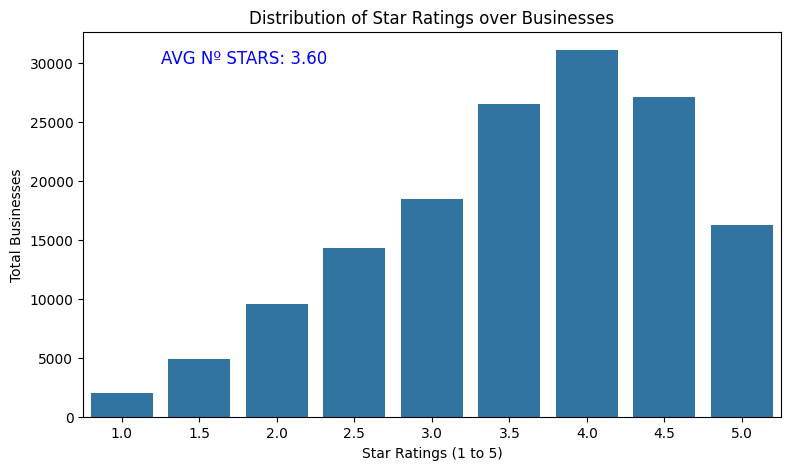

In [ ]:
# Businesses Star Rating Distribution
plt.figure(figsize=(9,5))

# Create the count plot
sns.countplot(data=df, x='stars')

# Calculate the avg star rating
average_star_rating = df['stars'].mean()

# Add the average star rating as a label on the plot
plt.text(x=0.5, y=30000, s=f'AVG Nº STARS: {average_star_rating:.2f}', color='blue', fontsize=12)

# Add the title and labels
plt.title('Distribution of Star Ratings over Businesses')
plt.xlabel('Star Ratings (1 to 5)')
plt.ylabel('Total Businesses')

# Show the plot
plt.show()


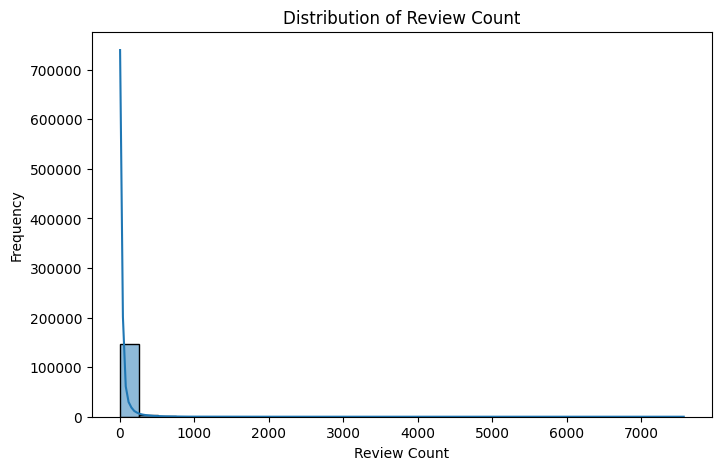

In [ ]:
# Review count distribution
plt.figure(figsize=(8,5))
sns.histplot(df['review_count'], bins=30, kde=True)
plt.title('Distribution of Review Count')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.show()

right-skewed distribution, where most businesses have few reviews (hence the large bar on the left) and a small number of businesses have a very high number of reviews (the tail on the right).

This type of skew is common in many real-world datasets, including review counts, where a few businesses receive a disproportionate number of reviews while most businesses receive relatively few.

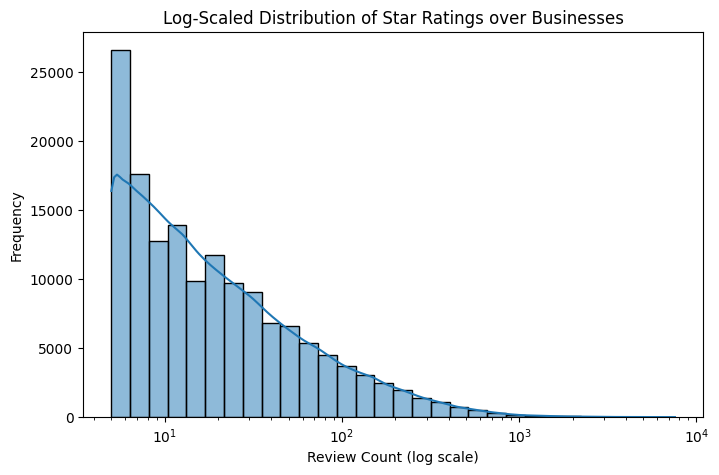

In [ ]:
# Review of Businesses with count distribution with log scale
plt.figure(figsize=(8,5))

#Create an histogram with log scaling
sns.histplot(df['review_count'], bins=30, kde=True, log_scale=(True, False))

plt.title('Log-Scaled Distribution of Star Ratings over Businesses')
plt.xlabel('Review Count (log scale)')
plt.ylabel('Frequency')
plt.show()


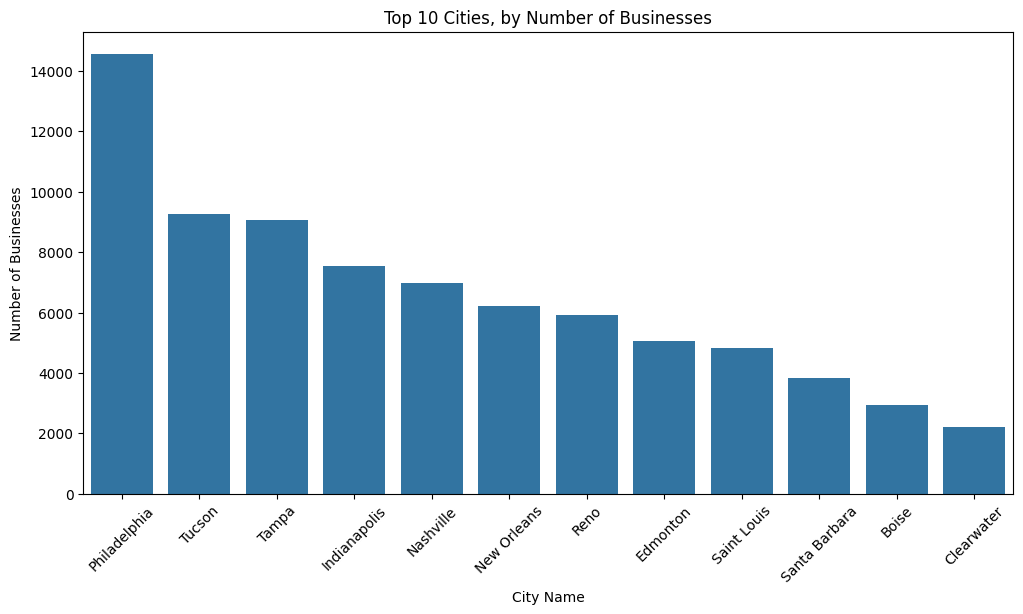

In [ ]:

# Plot the Location (city/state) business count distribution
plt.figure(figsize=(12,6))
top_cities = df['city'].value_counts().head(12)
sns.barplot(x=top_cities.index, y=top_cities.values)
plt.title('Top 10 Cities, by Number of Businesses')
plt.xlabel('City Name')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=45)
plt.show()

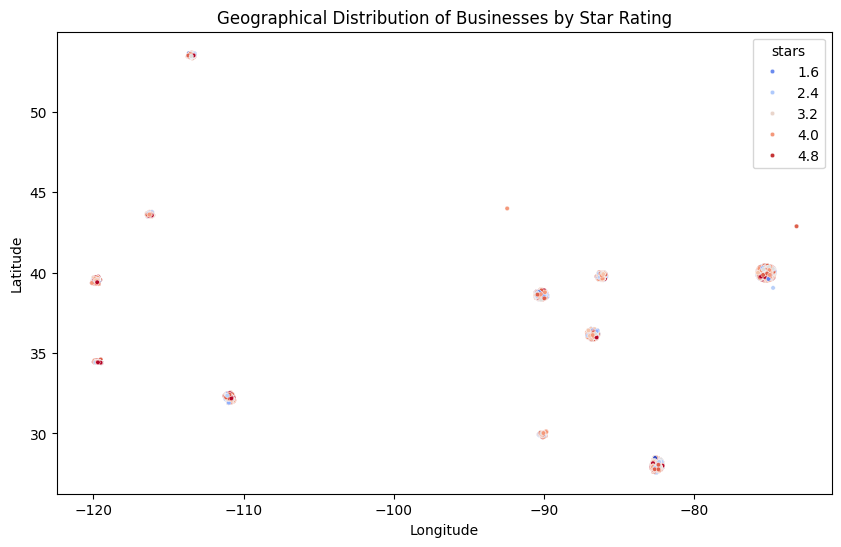

In [ ]:
# Distribution of Latitude and Longitude of Businesses by Star Rating
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='stars', palette='coolwarm', s=10)
plt.title('Geographical Distribution of Businesses by Star Rating')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

 The plot shows that businesses with higher star ratings tend to cluster in certain areas, while those with lower ratings are more dispersed.

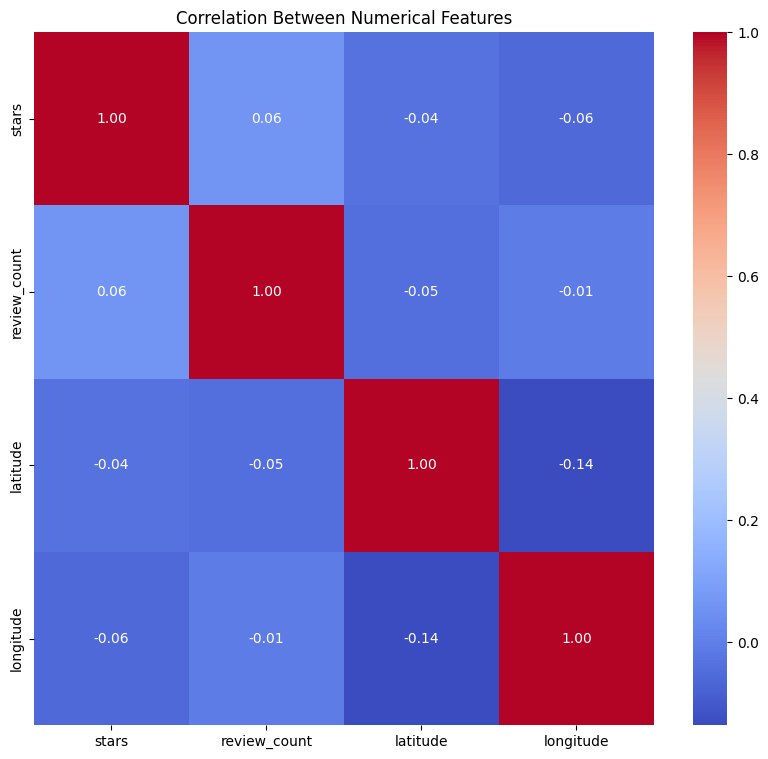

In [ ]:
# Create a Correlation Matrix with correlation between numeric features
corr_matrix_yelp = df[['stars', 'review_count', 'latitude', 'longitude']].corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr_matrix_yelp, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Numerical Features')
plt.show()

Ver relaçoes quadraticas. ver variaveis 2 a 2 -pairplot ()

1. Stars and review_count:

Positive correlation: The correlation coefficient between stars and review_count is 0.06, indicating a slight positive correlation. This suggests that businesses with higher star ratings tend to have more reviews, but the relationship is weak.
2. Stars and latitude/longitude:

No significant correlation: The correlation coefficients between stars and latitude/longitude are -0.04 and -0.06, respectively. These values are close to zero, indicating no significant correlation. This means that the location of a business (latitude and longitude) does not have a strong influence on its star rating.

3. Review_count and latitude/longitude:

No significant correlation: The correlation coefficients between review_count and latitude/longitude are -0.05 and -0.01, respectively. These values are also close to zero, suggesting no significant correlation. This means that the location of a business does not have a strong influence on the number of reviews it receives.

In [ ]:
# 5. Textual Data Analysis
# Top 10 most common business names
top_businesses_names = df['name'].value_counts().head(10)
print("\nTop 10 most common Businesses' names:")
print(top_businesses_names)


Top 10 most common Businesses' names:
name
Starbucks       724
McDonald's      703
Dunkin'         510
Subway          459
Taco Bell       365
CVS Pharmacy    345
Walgreens       341
Burger King     338
Wendy's         331
Wawa            307
Name: count, dtype: int64


In [ ]:
# 7. Attributes Exploration
# Convert 'attributes' column from string to dictionary (if needed)
df['attributes'] = df['attributes'].apply(lambda x: ast.literal_eval(str(x)) if pd.notnull(x) else {})

# Summary of attributes
all_attributes = pd.json_normalize(df['attributes'])
print("\nAttributes available in the dataset:")
print(all_attributes.columns)

# Checking correlation between specific attributes (e.g., Wi-Fi and Star Ratings)
if 'Wi-Fi' in all_attributes.columns:
    wifi_star_corr = all_attributes['Wi-Fi'].value_counts().sort_index()
    print("\nWi-Fi availability vs. Number of Businesses:")
    print(wifi_star_corr)






Attributes available in the dataset:
Index(['ByAppointmentOnly', 'BusinessAcceptsCreditCards', 'BikeParking',
       'RestaurantsPriceRange2', 'CoatCheck', 'RestaurantsTakeOut',
       'RestaurantsDelivery', 'Caters', 'WiFi', 'BusinessParking',
       'WheelchairAccessible', 'HappyHour', 'OutdoorSeating', 'HasTV',
       'RestaurantsReservations', 'DogsAllowed', 'Alcohol', 'GoodForKids',
       'RestaurantsAttire', 'Ambience', 'RestaurantsTableService',
       'RestaurantsGoodForGroups', 'DriveThru', 'NoiseLevel', 'GoodForMeal',
       'BusinessAcceptsBitcoin', 'Smoking', 'Music', 'GoodForDancing',
       'AcceptsInsurance', 'BestNights', 'BYOB', 'Corkage', 'BYOBCorkage',
       'HairSpecializesIn', 'Open24Hours', 'RestaurantsCounterService',
       'AgesAllowed', 'DietaryRestrictions'],
      dtype='object')



Number of businesses open on each day:
Monday: 114474
Tuesday: 120631
Wednesday: 123771
Thursday: 125198
Friday: 124999
Saturday: 110770
Sunday: 81172


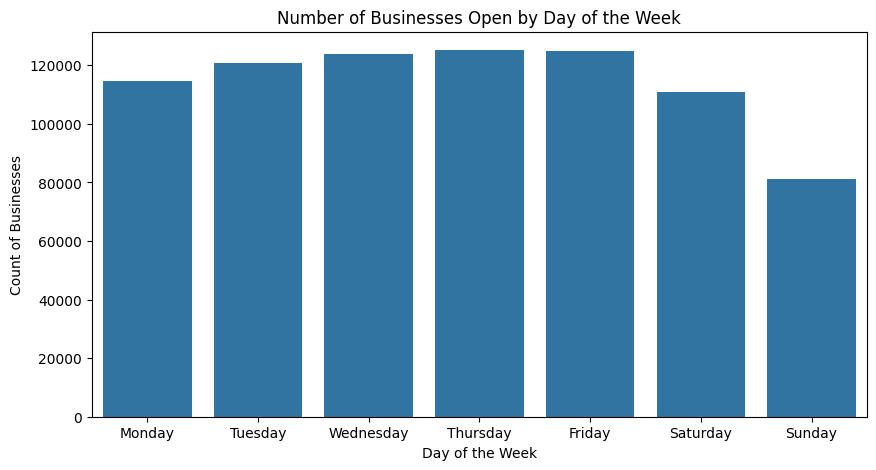

In [ ]:
# 8. Hours Exploration
# Convert 'hours' column from string to dictionary (if needed)
df['hours'] = df['hours'].apply(lambda x: ast.literal_eval(str(x)) if pd.notnull(x) else {})

# Example: Summarizing how many businesses are open on each day
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count how many businesses are open on each day
open_days_count = {day: df['hours'].apply(lambda x: day in x).sum() for day in days}
print("\nNumber of businesses open on each day:")
for day, count in open_days_count.items():
    print(f"{day}: {count}")


# Plotting the count of businesses open by day
plt.figure(figsize=(10,5))
sns.barplot(x=list(open_days_count.keys()), y=list(open_days_count.values()))
plt.title('Number of Businesses Open by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count of Businesses')
plt.show()